# Análisis Tipo de Cambio

El objetivo de este análisis es identificar la influencia de las principales variables economicas en el tipo de cambio USD - DOP.

Variables a analizar con respecto al tipo de cambio USD - DOP:

1. Nivel de Reservas en Millones de USD
2. Tasa Politica Monetaria BCRD
3. Llegada de pasajeros turistas en Miles de Personas
4. Exportaciones en Millones de USD
5. Remesas en Millones de USD

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel(r'M:\MIDDLE-OFFICE\COMUNES\0. GAF\Analisis Tipo de Cambio\DataConsolidada.xlsx', sheet_name='Data')

In [3]:
df.head()

,Fecha,ExportUSDMM,ReservUSDMM,TPM,Turistas,Remesas,TC
0,2012-01-31,478.892452,3046.8,0.0675,480.044,300.039840,38.858355
1,2012-02-29,503.834791,2980.1,0.0675,474.935,366.658553,38.942515
2,2012-03-31,659.810339,3031.0,0.0675,511.653,409.431621,38.994382
3,2012-04-30,546.674173,3125.5,0.0675,441.475,327.994910,39.017556
4,2012-05-31,661.985431,3012.3,0.0675,352.566,341.065591,39.022152


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Fecha        127 non-null    datetime64[ns]
 1   ExportUSDMM  127 non-null    float64       
 2   ReservUSDMM  127 non-null    float64       
 3   TPM          127 non-null    float64       
 4   Turistas     127 non-null    float64       
 5   Remesas      127 non-null    float64       
 6   TC           127 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 7.1 KB


In [5]:
pd.options.display.float_format = '{:,.2f}'.format
df.describe()

,ExportUSDMM,ReservUSDMM,TPM,Turistas,Remesas,TC
count,127.00,127.00,127.00,127.00,127.00,127.00
mean,770.90,"6,802.11",0.05,494.09,526.65,48.10
std,141.38,"3,238.95",0.01,155.97,179.84,5.81
min,478.89,"2,980.10",0.03,1.38,262.32,38.86
25%,670.21,"4,462.30",0.05,422.56,391.58,43.57
50%,756.43,"6,248.75",0.05,507.43,474.03,47.28
75%,846.74,"7,954.31",0.06,606.86,602.27,52.80
max,"1,214.42","14,849.76",0.07,800.94,994.89,58.36


# Coeficientes de Variación

Determina la variable con mayor variabilidad

In [6]:
var_expor = df.describe()['ExportUSDMM']['std']/df.describe()['ExportUSDMM']['mean']
var_reserv = df.describe()['ReservUSDMM']['std']/df.describe()['ReservUSDMM']['mean']
var_tpm = df.describe()['TPM']['std']/df.describe()['TPM']['mean']
var_tur = df.describe()['Turistas']['std']/df.describe()['Turistas']['mean']
var_rem = df.describe()['Remesas']['std']/df.describe()['ExportUSDMM']['mean']
var = [var_expor,var_reserv,var_tpm,var_tur,var_rem]
var_df = pd.DataFrame(var, index=['Exportaciones','Reservas','TPM','Turistas','Remesas'], columns=['Coeficiente de Variación'])
var_df

,Coeficiente de Variación
Exportaciones,0.18
Reservas,0.48
TPM,0.21
Turistas,0.32
Remesas,0.23


<AxesSubplot:>

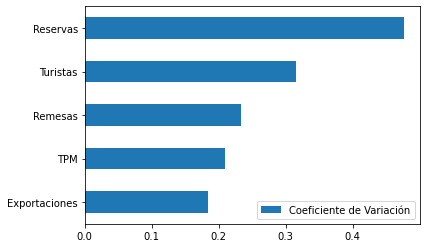

In [7]:
var_df.sort_values(by='Coeficiente de Variación').plot(kind='barh')

# Coeficientes de Variación sin periodo Covid

Determina la variable con mayor variabilidad excluyendo el 2020 pandemia.

In [8]:
df_nocovid = df[df['Fecha'].dt.year != 2020]

In [9]:
var_expor_cov = df_nocovid.describe()['ExportUSDMM']['std']/df.describe()['ExportUSDMM']['mean']
var_reserv_cov = df_nocovid.describe()['ReservUSDMM']['std']/df.describe()['ReservUSDMM']['mean']
var_tpm_cov = df_nocovid.describe()['TPM']['std']/df.describe()['TPM']['mean']
var_tur_cov = df_nocovid.describe()['Turistas']['std']/df.describe()['Turistas']['mean']
var_rem_cov = df_nocovid.describe()['Remesas']['std']/df.describe()['ExportUSDMM']['mean']
var_cov = [var_expor_cov,var_reserv_cov,var_tpm_cov,var_tur_cov,var_rem_cov]
var_df_cov = pd.DataFrame(var_cov, index=['Exportaciones','Reservas','TPM','Turistas','Remesas'], columns=['Coeficiente de Variación'])
var_df_cov

,Coeficiente de Variación
Exportaciones,0.19
Reservas,0.48
TPM,0.19
Turistas,0.24
Remesas,0.23


<AxesSubplot:>

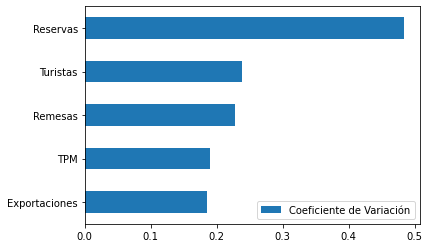

In [10]:
var_df_cov.sort_values(by='Coeficiente de Variación').plot(kind='barh')

# Graficos de tendencia individual

Se utiliza para analizar el comportamiento de las variables

In [11]:
df.set_index('Fecha',inplace=True)

In [12]:
#Funcion para automatizar la evaluacion de promedio moviles y valores atipicos
def GraficarPromedioMovil(df,ventana,intervalos=False,escala=2,anomalias=False):
    
    promedio_movil = df.rolling(window=ventana).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Promedio movil\n ventana = {}\n {}".format(ventana,df.columns[0]))
    plt.plot(promedio_movil,"g",label="Tendencia de Promedio Movil")
    
    if intervalos:
        error_absoluto_medio = mean_absolute_error(df[ventana:],df.rolling(window=ventana).mean()[ventana:])
        desviacion_error = np.std(df[ventana:] - df.rolling(window=ventana).mean()[ventana:])
        banda_inferior = df.rolling(window=ventana).mean()[ventana:] - (error_absoluto_medio + escala*desviacion_error)
        banda_superior = df.rolling(window=ventana).mean()[ventana:] + (error_absoluto_medio + escala*desviacion_error)
        plt.plot(banda_superior,"r--", label="Banda Superior /Banda Inferior")
        plt.plot(banda_inferior,"r--")
        
    if anomalias:
        anomalias = pd.DataFrame(index=df.index, columns=df.columns)
        anomalias[df[ventana:]<banda_inferior] = df[ventana:][df[ventana:]<banda_inferior]
        anomalias[df[ventana:]>banda_superior] = df[ventana:][df[ventana:]>banda_superior]
        plt.plot(anomalias,"ro",markersize=10)
        
    plt.plot(df[ventana:], label="Valores reales")
    plt.legend(loc="upper left")
    plt.grid(True)

In [13]:
exportaciones = pd.DataFrame(df['ExportUSDMM'])
reservas = pd.DataFrame(df['ReservUSDMM'])
tpm = pd.DataFrame(df['TPM'])
turistas = pd.DataFrame(df['Turistas'])
remesas = pd.DataFrame(df['Remesas'])
tc = pd.DataFrame(df['TC'])

# Remesas

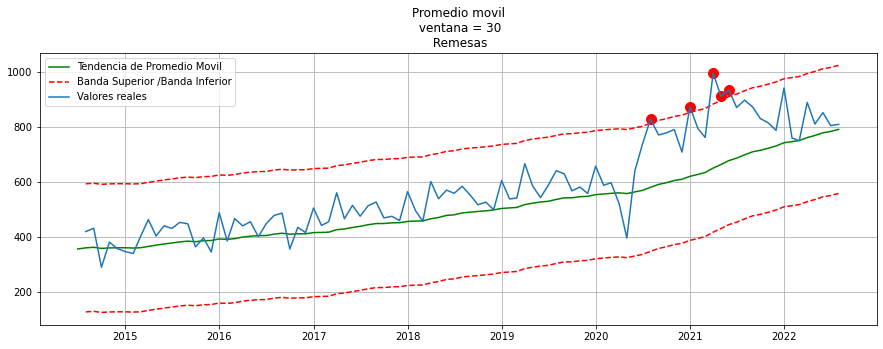

In [14]:
GraficarPromedioMovil(remesas,30,intervalos=True,anomalias=True)

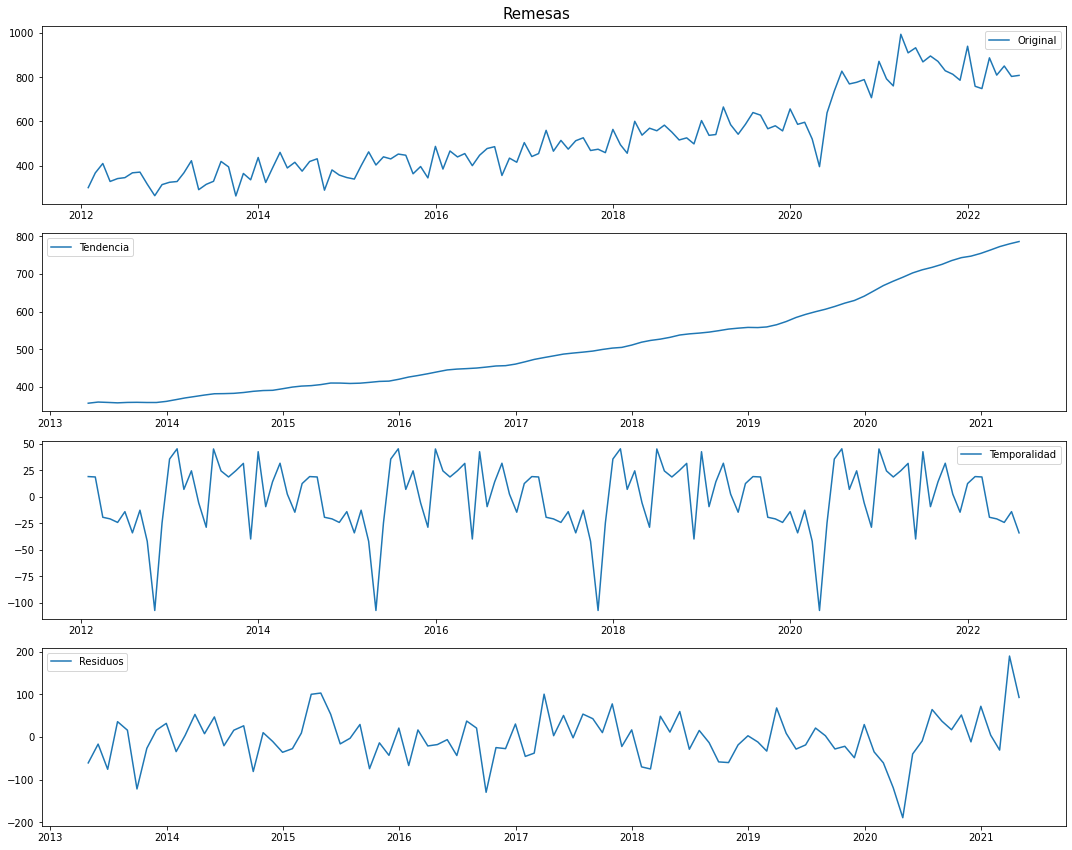

In [15]:
decomposition = seasonal_decompose(remesas,period = 30)

tendencia = decomposition.trend
temporalidad = decomposition.seasonal
residuos = decomposition.resid
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(remesas, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(temporalidad,label='Temporalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuos, label='Residuos')
plt.legend(loc='best')
plt.suptitle('Remesas',fontsize=15)
plt.tight_layout()

# Exportaciones

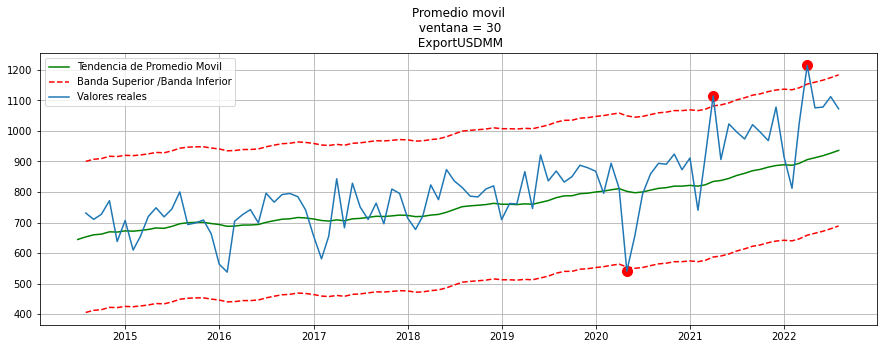

In [16]:
GraficarPromedioMovil(exportaciones,30,intervalos=True,anomalias=True)

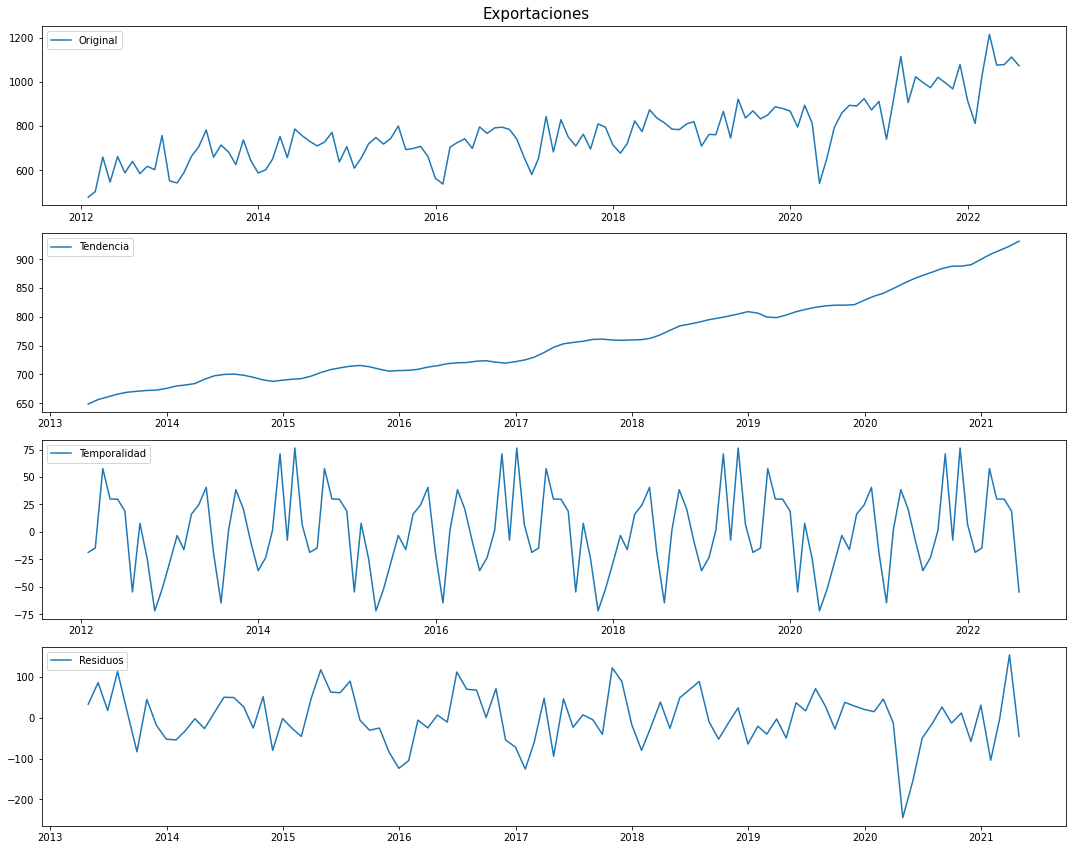

In [17]:
decomposition = seasonal_decompose(exportaciones,period = 30)

tendencia = decomposition.trend
temporalidad = decomposition.seasonal
residuos = decomposition.resid
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(exportaciones, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(temporalidad,label='Temporalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuos, label='Residuos')
plt.legend(loc='best')
plt.suptitle('Exportaciones',fontsize=15)
plt.tight_layout()

# Reservas

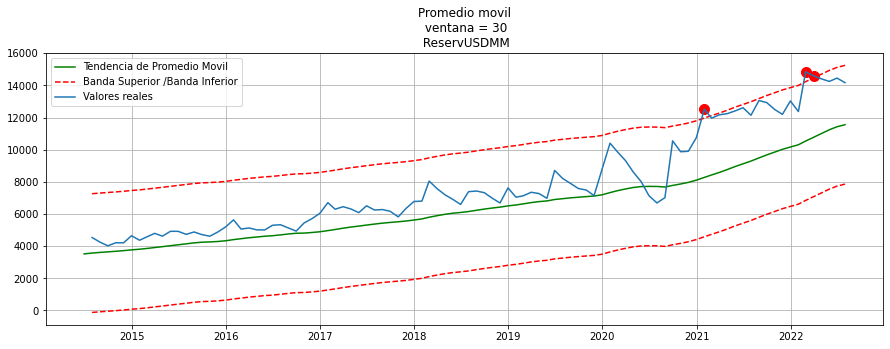

In [18]:
GraficarPromedioMovil(reservas,30,intervalos=True,anomalias=True)

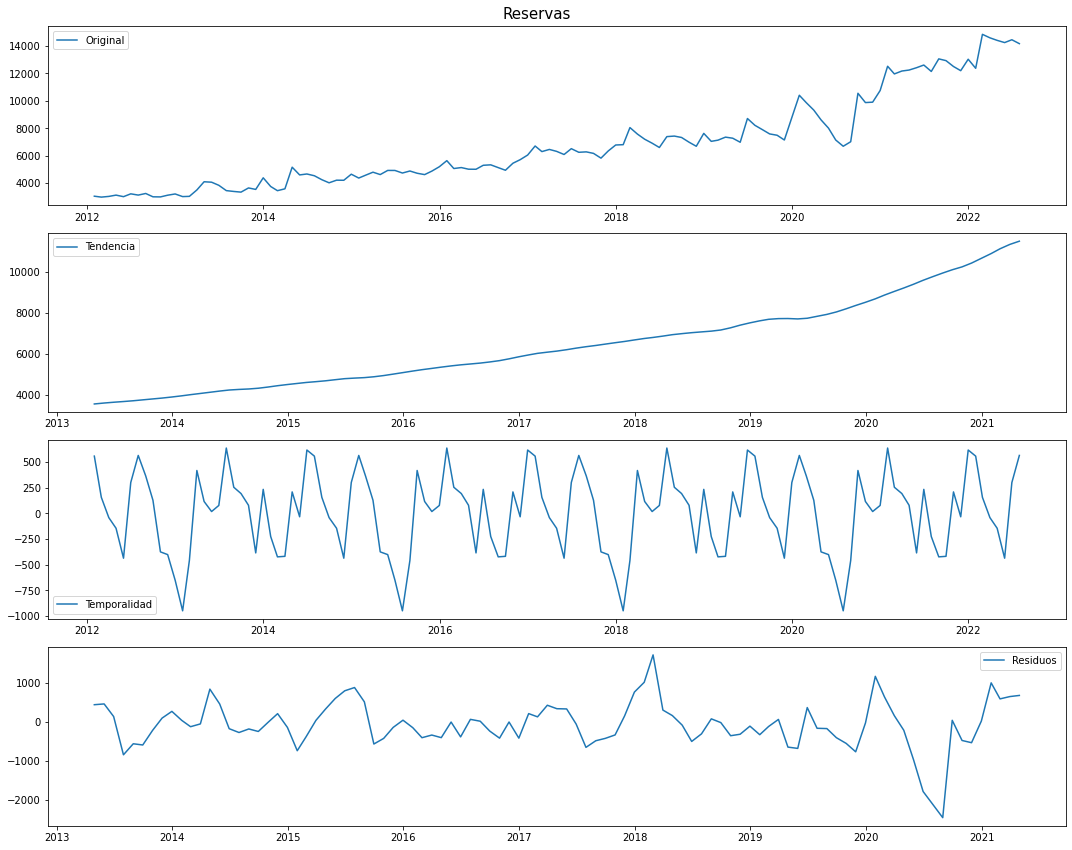

In [19]:
decomposition = seasonal_decompose(reservas,period = 30)

tendencia = decomposition.trend
temporalidad = decomposition.seasonal
residuos = decomposition.resid
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(reservas, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(temporalidad,label='Temporalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuos, label='Residuos')
plt.legend(loc='best')
plt.suptitle('Reservas',fontsize=15)
plt.tight_layout()

# Tasa Politica Monetaria

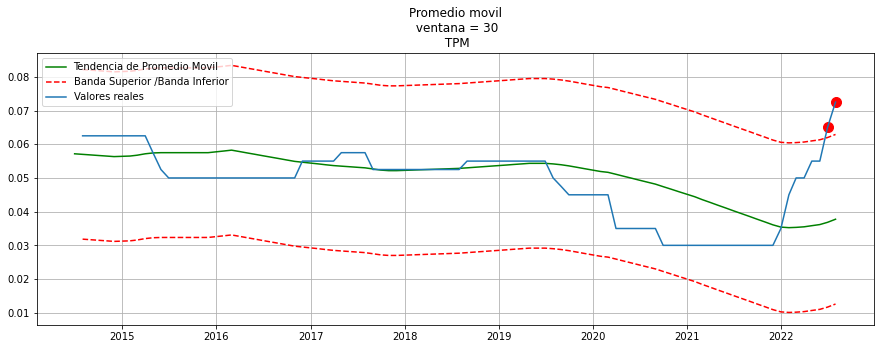

In [20]:
GraficarPromedioMovil(tpm,30,intervalos=True,anomalias=True)

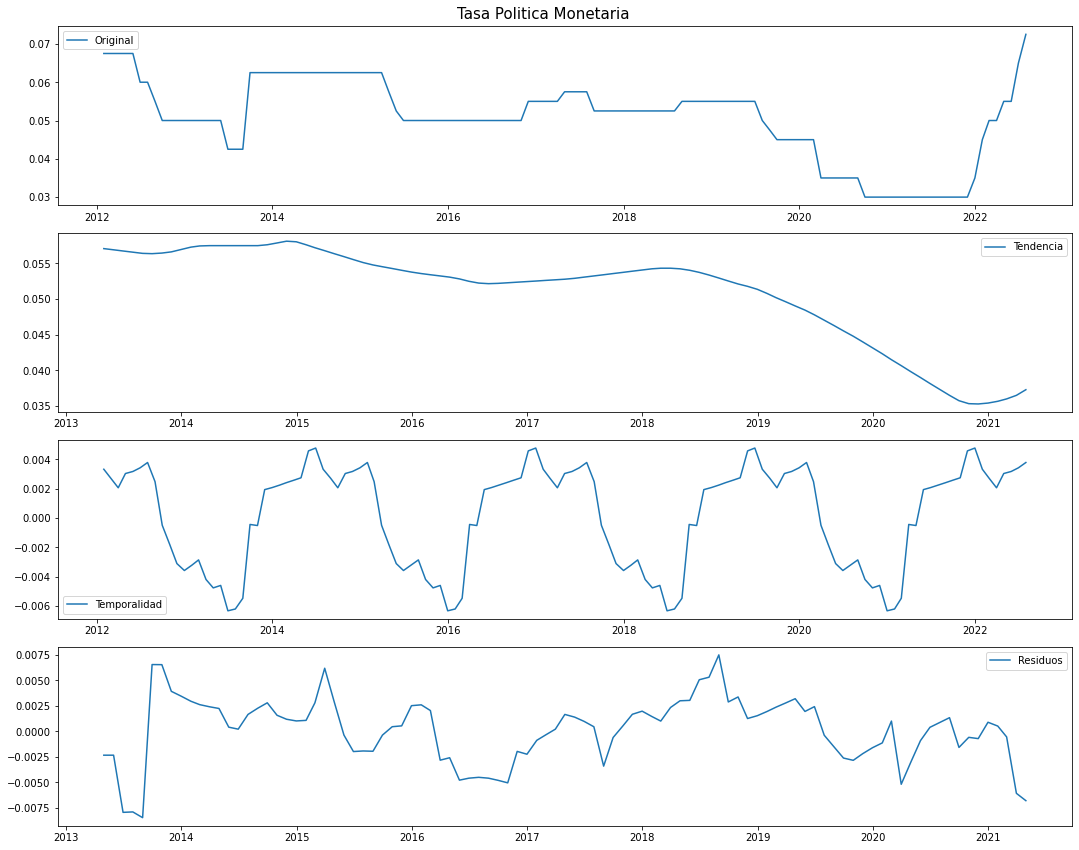

In [21]:
decomposition = seasonal_decompose(tpm,period = 30)

tendencia = decomposition.trend
temporalidad = decomposition.seasonal
residuos = decomposition.resid
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(tpm, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(temporalidad,label='Temporalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuos, label='Residuos')
plt.legend(loc='best')
plt.suptitle('Tasa Politica Monetaria',fontsize=15)
plt.tight_layout()

# Llegada de Turistas

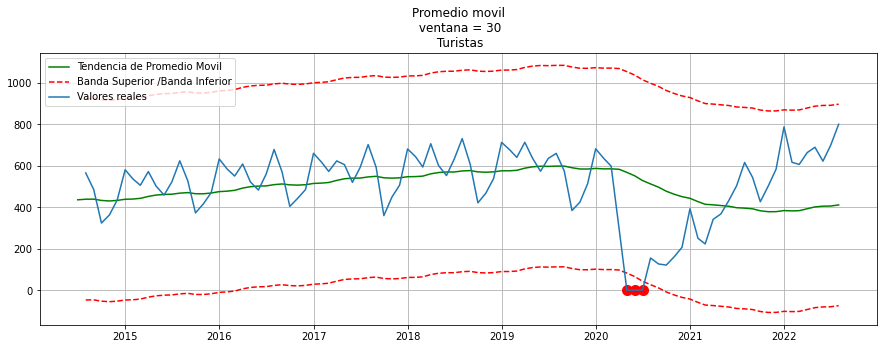

In [22]:
GraficarPromedioMovil(turistas,30,intervalos=True,anomalias=True)

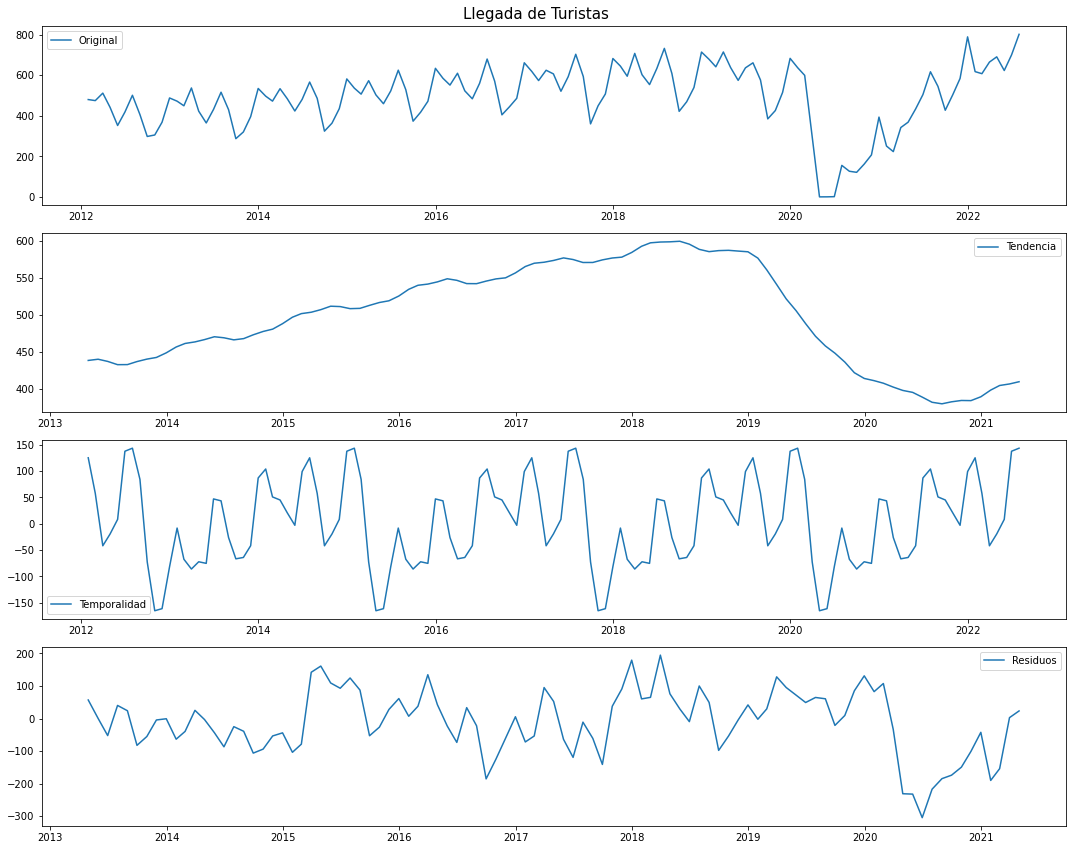

In [23]:
decomposition = seasonal_decompose(turistas,period = 30)

tendencia = decomposition.trend
temporalidad = decomposition.seasonal
residuos = decomposition.resid
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(turistas, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(temporalidad,label='Temporalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuos, label='Residuos')
plt.legend(loc='best')
plt.suptitle('Llegada de Turistas',fontsize=15)
plt.tight_layout()

# Tipo de Cambio

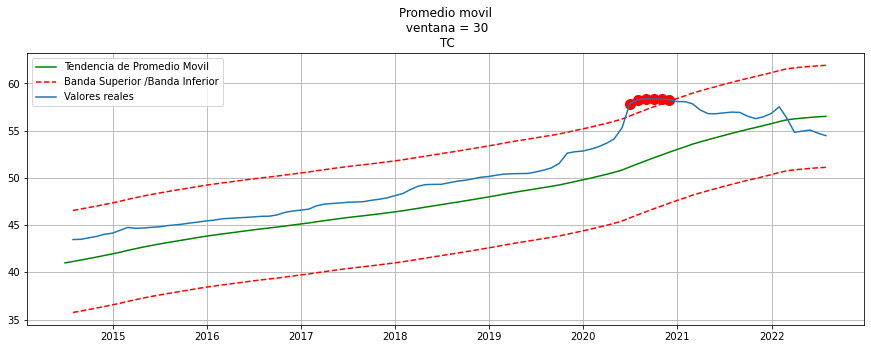

In [24]:
GraficarPromedioMovil(tc,30,intervalos=True,anomalias=True)

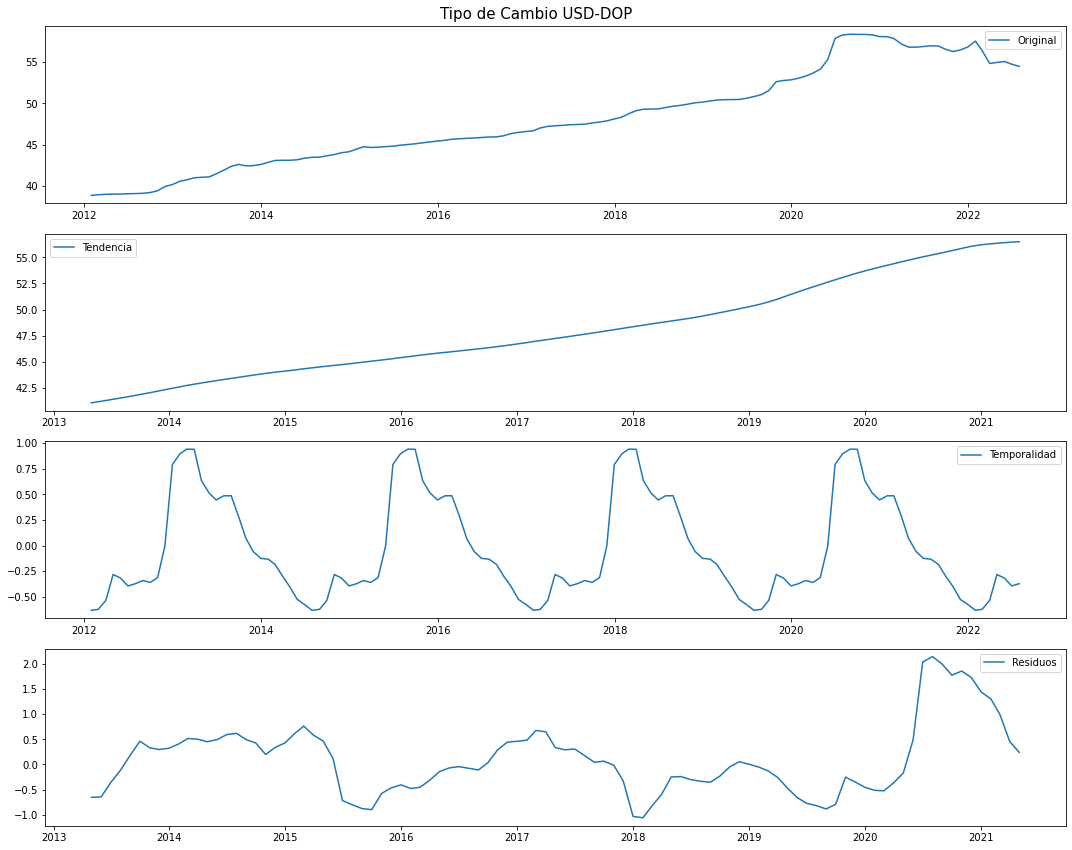

In [25]:
decomposition = seasonal_decompose(tc,period = 30)

tendencia = decomposition.trend
temporalidad = decomposition.seasonal
residuos = decomposition.resid
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(tc, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(temporalidad,label='Temporalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuos, label='Residuos')
plt.legend(loc='best')
plt.suptitle('Tipo de Cambio USD-DOP',fontsize=15)
plt.tight_layout()

# Análisis tendencia de variables escala normalizada

Se utiliza para poder comparar las tendencias de todas las variables en una misma escala.

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()

exportaciones['normalizado'] = scaler.fit_transform(exportaciones)

In [28]:
scaler = MinMaxScaler()

reservas['normalizado'] = scaler.fit_transform(reservas)

In [29]:
scaler = MinMaxScaler()

tpm['normalizado'] = scaler.fit_transform(tpm)

In [30]:
scaler = MinMaxScaler()

turistas['normalizado'] = scaler.fit_transform(turistas)

In [31]:
scaler = MinMaxScaler()

remesas['normalizado'] = scaler.fit_transform(remesas)

In [32]:
scaler = MinMaxScaler()

tc['normalizado'] = scaler.fit_transform(tc)

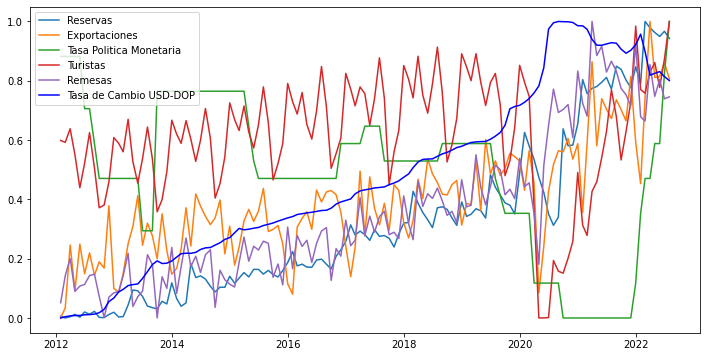

In [33]:
plt.figure(figsize=(12,6))
plt.plot(reservas['normalizado'], label = 'Reservas')
plt.plot(exportaciones['normalizado'], label = 'Exportaciones')
plt.plot(tpm['normalizado'], label = 'Tasa Politica Monetaria')
plt.plot(turistas['normalizado'], label = 'Turistas')
plt.plot(remesas['normalizado'], label = 'Remesas')
plt.plot(tc['normalizado'], label = 'Tasa de Cambio USD-DOP', color='b')
plt.legend(loc='best')
plt.show()

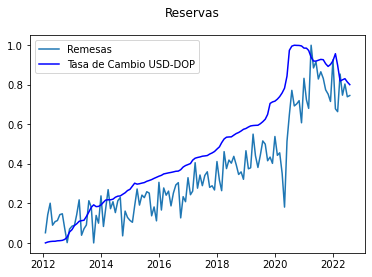

In [34]:
plt.plot(remesas['normalizado'], label = 'Remesas')
plt.plot(tc['normalizado'], label = 'Tasa de Cambio USD-DOP', color='b')
plt.legend(loc='best')
plt.suptitle('Remesas')
plt.show()

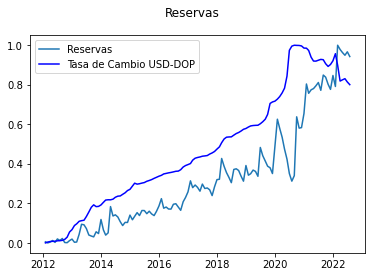

In [35]:
plt.plot(reservas['normalizado'], label = 'Reservas')
plt.plot(tc['normalizado'], label = 'Tasa de Cambio USD-DOP', color='b')
plt.legend(loc='best')
plt.suptitle('Reservas')
plt.show()

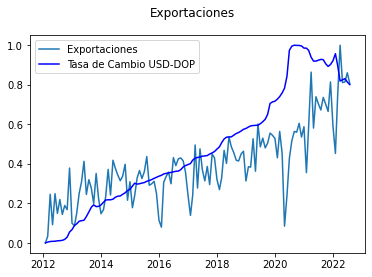

In [36]:
plt.plot(exportaciones['normalizado'], label = 'Exportaciones')
plt.plot(tc['normalizado'], label = 'Tasa de Cambio USD-DOP', color='b')
plt.legend(loc='best')
plt.suptitle('Exportaciones')
plt.show()

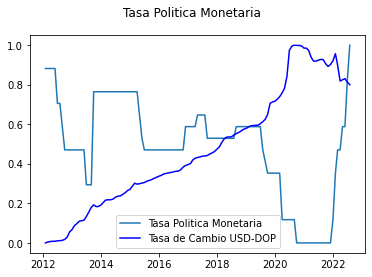

In [37]:
plt.plot(tpm['normalizado'], label = 'Tasa Politica Monetaria')
plt.plot(tc['normalizado'], label = 'Tasa de Cambio USD-DOP', color='b')
plt.legend(loc='best')
plt.suptitle('Tasa Politica Monetaria')
plt.show()

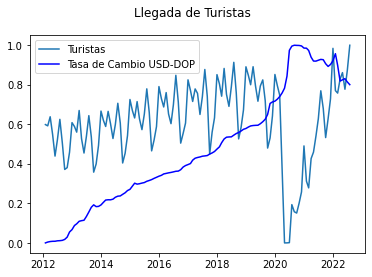

In [38]:
.plt.plot(turistas['normalizado'], label = 'Turistas')
plt.plot(tc['normalizado'], label = 'Tasa de Cambio USD-DOP', color='b')
plt.legend(loc='best')
plt.suptitle('Llegada de Turistas')
plt.show()

# Análisis de relación de variables

Se utilizara poder analizar cuales variables están correlacionadas y que tanto.

In [39]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

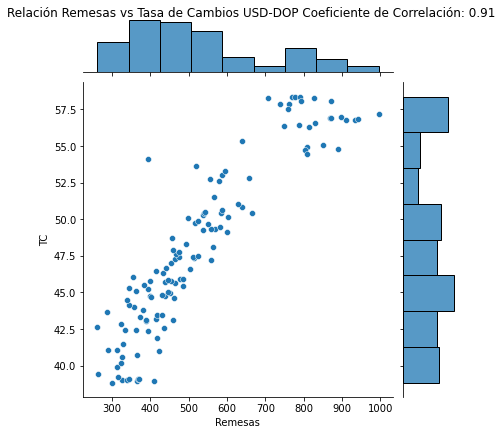

In [40]:
sns.jointplot(data=df, x="Remesas", y="TC")
plt.suptitle("Relación Remesas vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['Remesas'],df['TC'])[0][1],2)),y = 1)
plt.show()

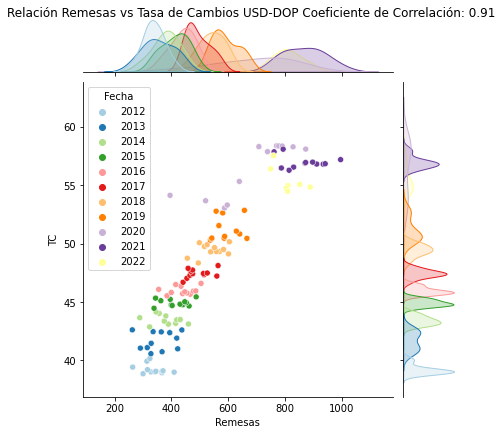

In [41]:
sns.jointplot(data=df, x="Remesas", y="TC", hue=df.index.year,palette="Paired")
plt.suptitle("Relación Remesas vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['Remesas'],df['TC'])[0][1],2)),y = 1)
plt.show()

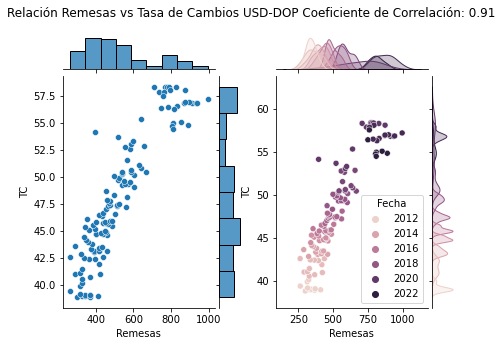

In [42]:
g0 = sns.jointplot(data=df, x="Remesas", y="TC")
g1 = sns.jointplot(data=df, x="Remesas", y="TC", hue=df.index.year)

fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(1, 2)
plt.suptitle("Relación Remesas vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['Remesas'],df['TC'])[0][1],2)))

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])

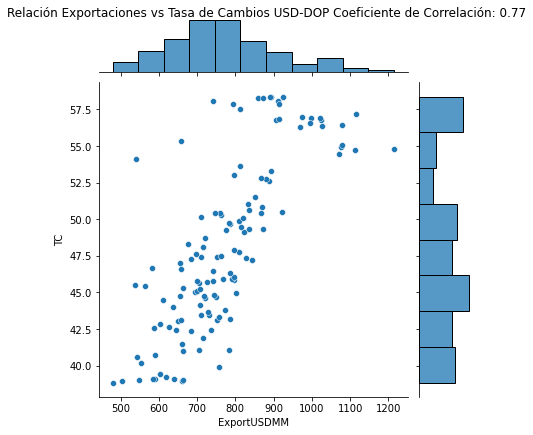

In [43]:
sns.jointplot(data=df, x="ExportUSDMM", y="TC")
plt.suptitle("Relación Exportaciones vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['ExportUSDMM'],df['TC'])[0][1],2)), y=1)
plt.show()

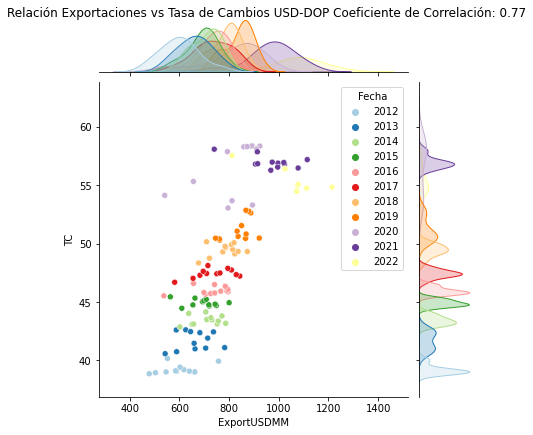

In [44]:
sns.jointplot(data=df, x="ExportUSDMM", y="TC", hue=df.index.year,palette="Paired")
plt.suptitle("Relación Exportaciones vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['ExportUSDMM'],df['TC'])[0][1],2)),y = 1)
plt.show()

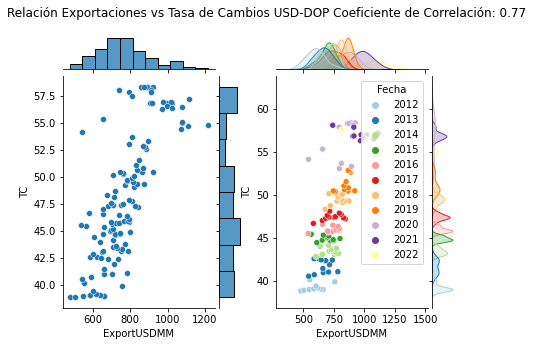

In [45]:
g0 = sns.jointplot(data=df, x="ExportUSDMM", y="TC")
g1 = sns.jointplot(data=df, x="ExportUSDMM", y="TC", hue=df.index.year,palette="Paired")

fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(1, 2)
plt.suptitle("Relación Exportaciones vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['ExportUSDMM'],df['TC'])[0][1],2)))

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])

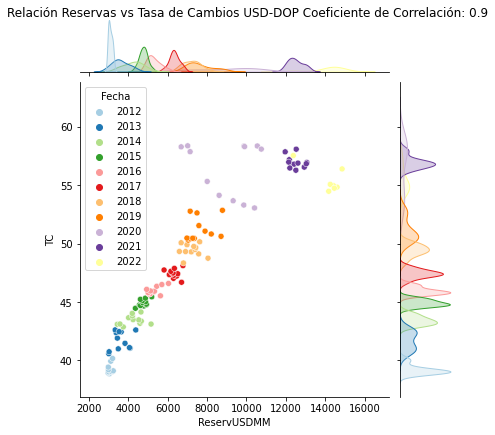

In [46]:
sns.jointplot(data=df, x="ReservUSDMM", y="TC", hue=df.index.year,palette="Paired")
plt.suptitle("Relación Reservas vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['ReservUSDMM'],df['TC'])[0][1],2)),y = 1)
plt.show()

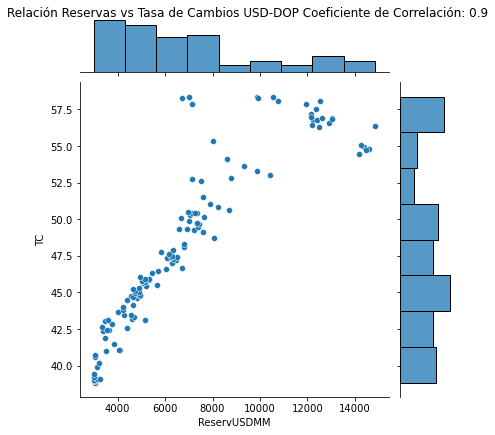

In [47]:
sns.jointplot(data=df, x="ReservUSDMM", y="TC")
plt.suptitle("Relación Reservas vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['ReservUSDMM'],df['TC'])[0][1],2)),y = 1)
plt.show()

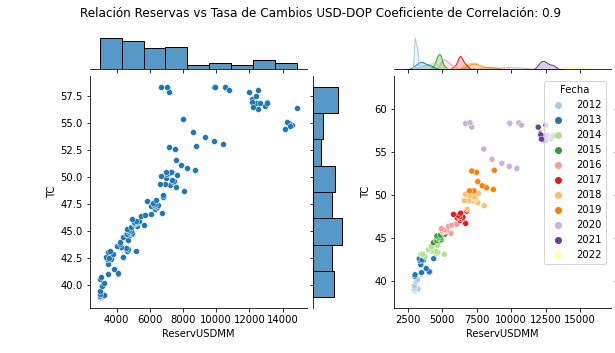

In [48]:
g0 = sns.jointplot(data=df, x="ReservUSDMM", y="TC")
g1 = sns.jointplot(data=df, x="ReservUSDMM", y="TC", hue=df.index.year,palette="Paired")

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2)
plt.suptitle("Relación Reservas vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['ReservUSDMM'],df['TC'])[0][1],2)))

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])

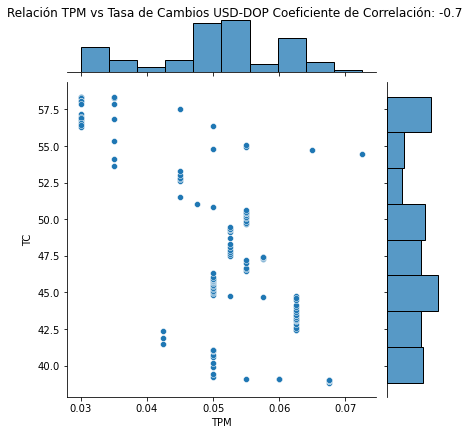

In [49]:
sns.jointplot(data=df, x="TPM", y="TC")
plt.suptitle("Relación TPM vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['TPM'],df['TC'])[0][1],2)),y = 1)
plt.show()

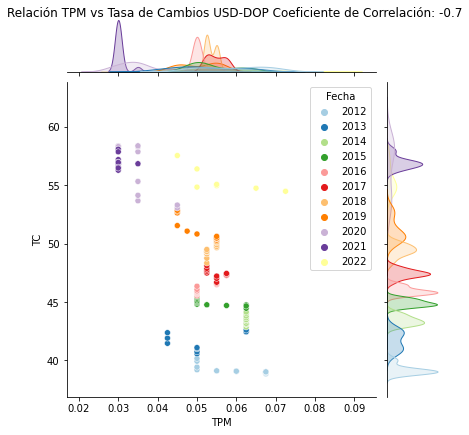

In [50]:
sns.jointplot(data=df, x="TPM", y="TC", hue=df.index.year,palette="Paired")
plt.suptitle("Relación TPM vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['TPM'],df['TC'])[0][1],2)),y = 1)
plt.show()

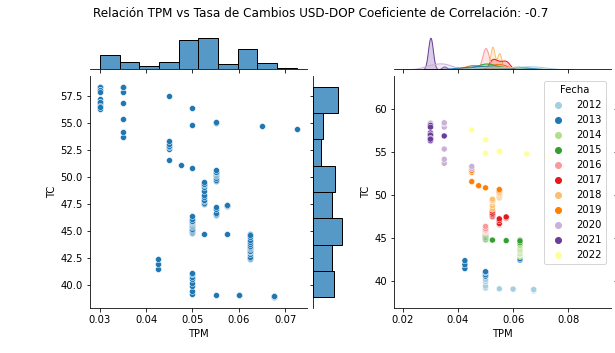

In [51]:
g0 = sns.jointplot(data=df, x="TPM", y="TC")
g1 = sns.jointplot(data=df, x="TPM", y="TC", hue=df.index.year,palette="Paired")

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2)
plt.suptitle("Relación TPM vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['TPM'],df['TC'])[0][1],2)))

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])

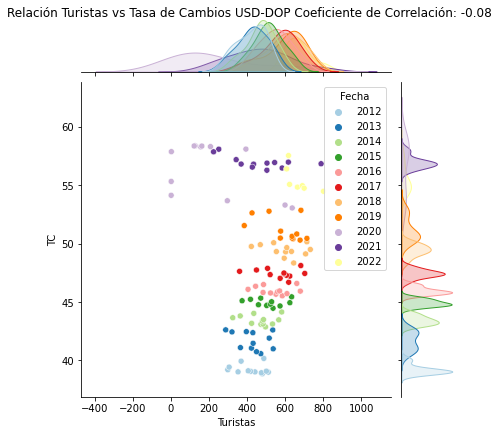

In [52]:
sns.jointplot(data=df, x="Turistas", y="TC", hue=df.index.year,palette="Paired")
plt.suptitle("Relación Turistas vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['Turistas'],df['TC'])[0][1],2)),y = 1)
plt.show()

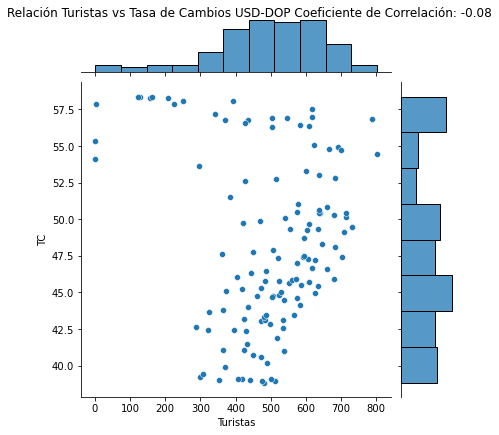

In [53]:
sns.jointplot(data=df, x="Turistas", y="TC")
plt.suptitle("Relación Turistas vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['Turistas'],df['TC'])[0][1],2)),y = 1)
plt.show()

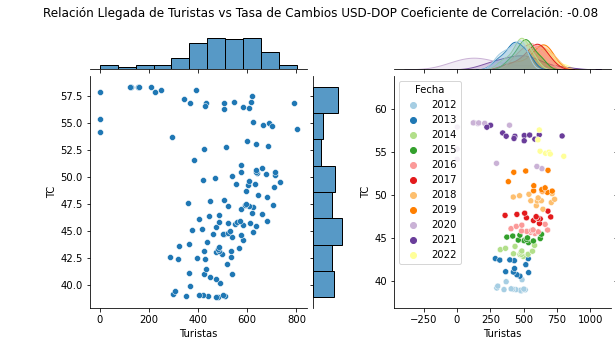

In [54]:
g0 = sns.jointplot(data=df, x="Turistas", y="TC")
g1 = sns.jointplot(data=df, x="Turistas", y="TC", hue=df.index.year,palette="Paired")

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2)
plt.suptitle("Relación Llegada de Turistas vs Tasa de Cambios USD-DOP Coeficiente de Correlación: {}".format(round(np.corrcoef(df['Turistas'],df['TC'])[0][1],2)))

mg0 = SeabornFig2Grid(g0, fig, gs[0])#Sin Covid
mg1 = SeabornFig2Grid(g1, fig, gs[1])

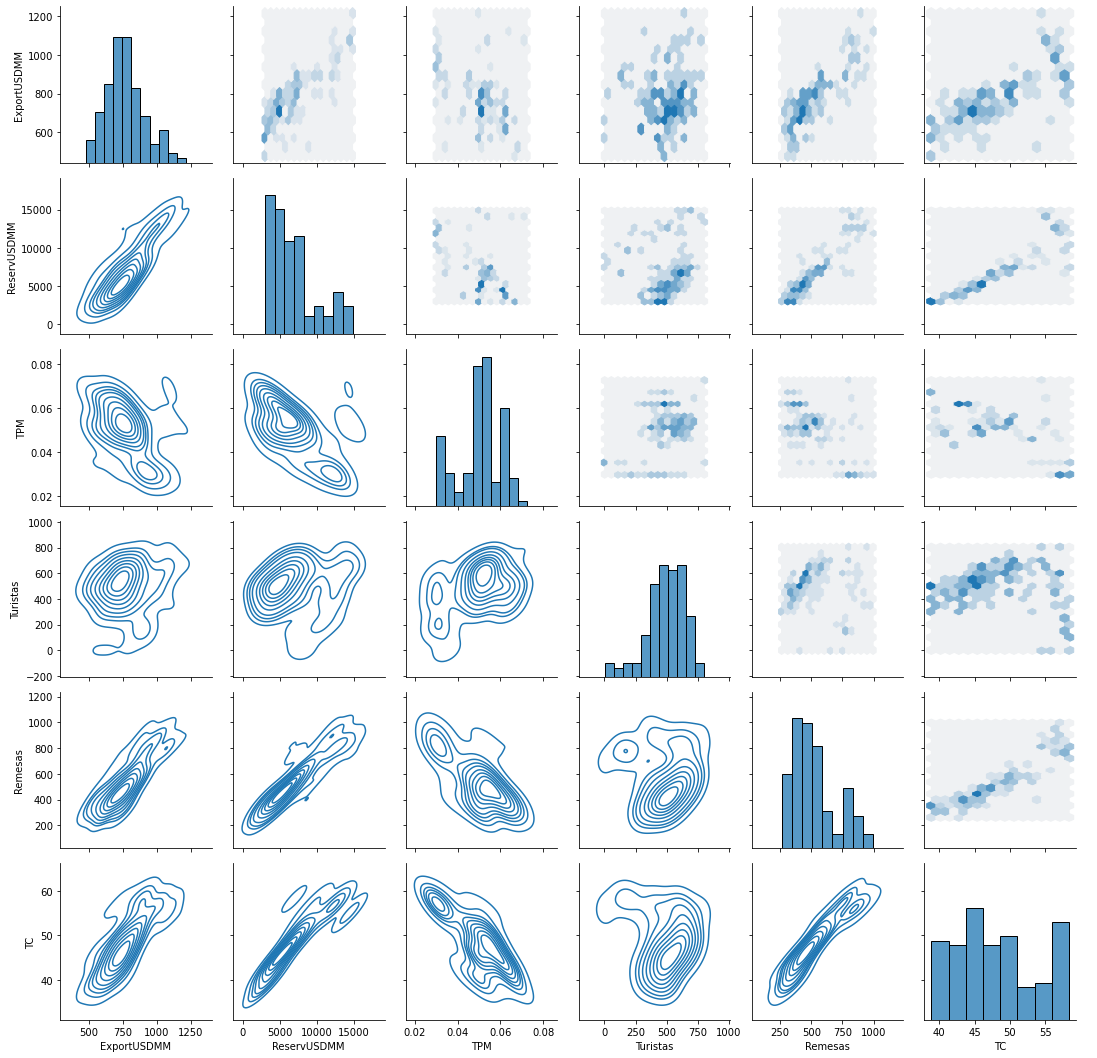

In [55]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, extent=[min(x), max(x), min(y), max(y)], **kwargs)



g = sns.PairGrid(df)
g.map_upper(hexbin)
g.map_diag(sns.histplot)
g.map_lower(sns.kdeplot)
g.add_legend()
plt.show()

In [56]:
df_orig = df.copy()
df_orig['anio'] = df.index.year

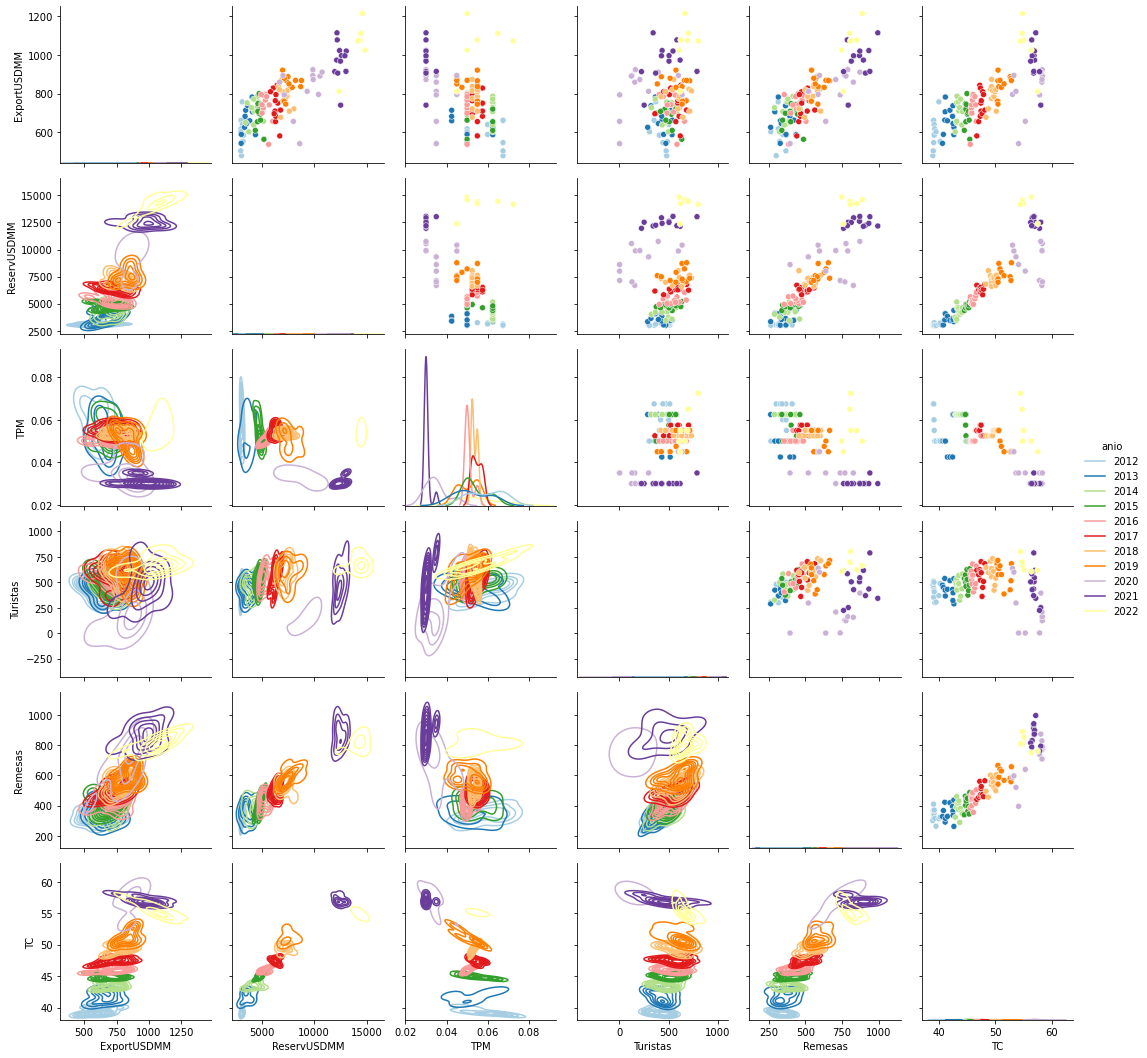

In [57]:
g = sns.PairGrid(df_orig, hue = 'anio',palette="Paired")
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.add_legend()
plt.show()

# Mapa de calor

<AxesSubplot:>

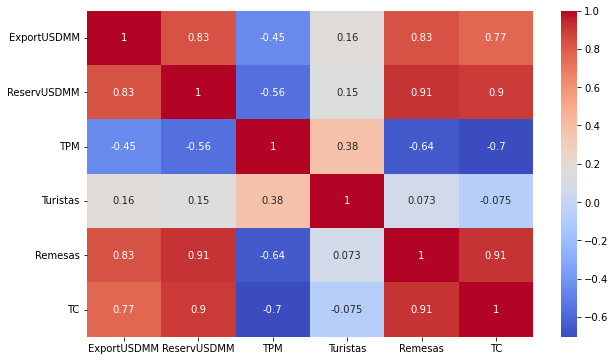

In [58]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True,cmap='coolwarm')

<AxesSubplot:>

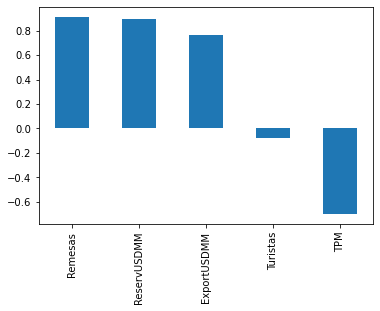

In [59]:
df.corr()['TC'].sort_values(ascending=False)[1:].plot(kind='bar')

In [60]:
df.corr()['TC'].sort_values(ascending=False)[1:]

Remesas        0.91
ReservUSDMM    0.90
ExportUSDMM    0.77
Turistas      -0.08
TPM           -0.70
Name: TC, dtype: float64

# Análisis de Variabilidad a traves del tiempo

Con esto podemos comparar la variabilidad en los diferentes años

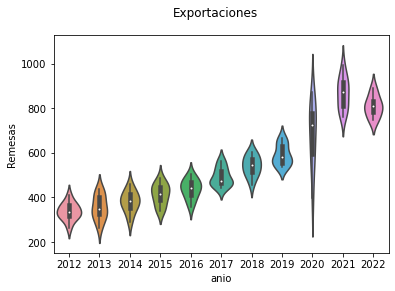

In [61]:
sns.violinplot(y='Remesas',x='anio',data=df_orig)
plt.suptitle('Remesas')
plt.show()

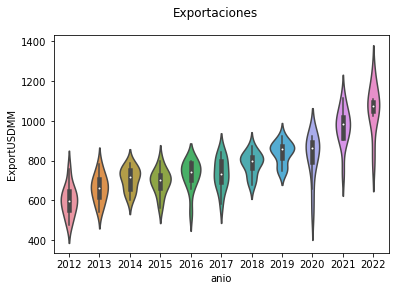

In [62]:
sns.violinplot(y='ExportUSDMM',x='anio',data=df_orig)
plt.suptitle('Exportaciones')
plt.show()

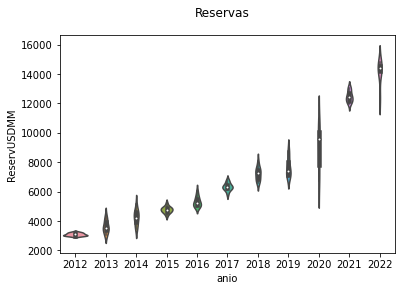

In [63]:
sns.violinplot(y='ReservUSDMM',x='anio',data=df_orig)
plt.suptitle('Reservas')
plt.show()

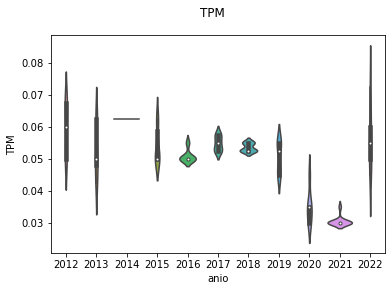

In [64]:
sns.violinplot(y='TPM',x='anio',data=df_orig)
plt.suptitle('TPM')
plt.show()

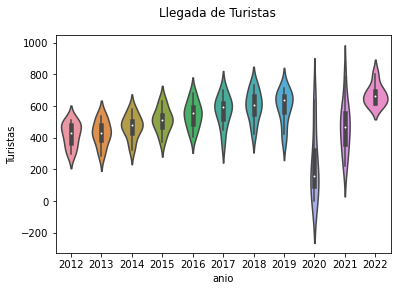

In [65]:
sns.violinplot(y='Turistas',x='anio',data=df_orig)
plt.suptitle('Llegada de Turistas')
plt.show()

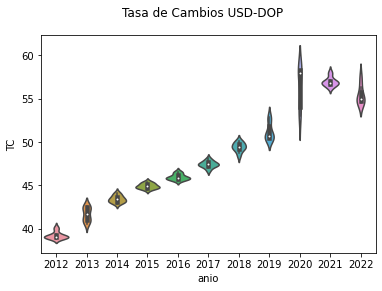

In [66]:
sns.violinplot(y='TC',x='anio',data=df_orig)
plt.suptitle('Tasa de Cambios USD-DOP')
plt.show()

In [67]:
pd.options.display.float_format = '{:,.2f}'.format
df_orig.groupby(['anio']).agg({'ExportUSDMM':['min','mean','std','max']}
                             ).transpose().style.background_gradient(cmap='RdYlGn_r',axis='columns').format("{:,.2f}")

In [68]:
df_orig.groupby(['anio']).agg({'Remesas':['min','mean','std','max']}
                             ).transpose().style.background_gradient(cmap='RdYlGn_r',axis='columns').format("{:,.2f}")

In [69]:
df_orig.groupby(['anio']).agg({'ReservUSDMM':['min','mean','std','max']}
                             ).transpose().style.background_gradient(cmap='RdYlGn_r',axis='columns').format("{:,.2f}")

In [70]:
df_orig.groupby(['anio']).agg({'TPM':['min','mean','std','max']}
                             ).transpose().style.background_gradient(cmap='RdYlGn_r',axis='columns').format("{:,.2f}")

In [71]:
df_orig.groupby(['anio']).agg({'Turistas':['min','mean','std','max']}
                             ).transpose().style.background_gradient(cmap='RdYlGn_r',axis='columns').format("{:,.2f}")

In [72]:
df_orig.groupby(['anio']).agg({'TC':['min','mean','std','max']}
                             ).transpose().style.background_gradient(cmap='RdYlGn_r',axis='columns').format("{:,.2f}")

# Análisis de regresión multiple con Tipo de Cambio

In [73]:
X = df.drop('TC', axis=1)
y = df['TC']

In [74]:
scaler = MinMaxScaler()

In [75]:
x_scale = scaler.fit_transform(X)

In [76]:
df_scale = pd.DataFrame(x_scale, columns=X.columns)

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(df_scale, y, test_size=0.15, random_state=42)

In [79]:
from sklearn.linear_model import LinearRegression

In [80]:
lr = LinearRegression()

In [81]:
lr.fit(X_train,y_train)

LinearRegression()

In [82]:
lr.intercept_

45.359216989988944

In [83]:
pd.options.display.float_format = '{:,.6f}'.format

df_coef = pd.DataFrame(lr.coef_, index=X.columns, columns=['Coeficientes'])
df_coef

,Coeficientes
ExportUSDMM,0.204056
ReservUSDMM,9.004129
TPM,-3.137765
Turistas,-4.022236
Remesas,10.493490


In [84]:
predicciones = lr.predict(X_test)

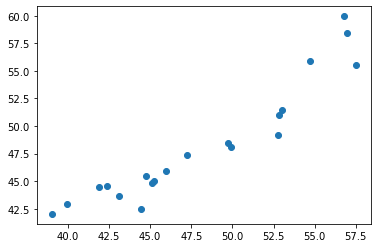

In [85]:
plt.scatter(y_test,predicciones)

<AxesSubplot:xlabel='TC', ylabel='Count'>

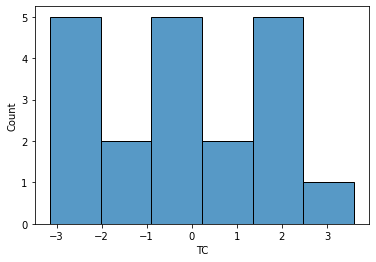

In [86]:
residuos = y_test - predicciones
sns.histplot(residuos)

In [87]:
comparacion = pd.concat([y.reset_index(drop=True),pd.Series(lr.predict(df_scale))], axis=1)
comparacion.columns = ['TC','Estimaciones']
comparacion.index = df.index

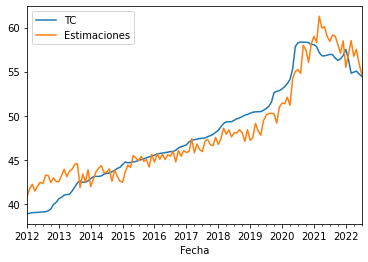

In [88]:
comparacion.plot()
plt.show()

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [90]:
print('Error Absoluto Medio: ', mean_absolute_error(y_test,predicciones))
print('Error Cuadratico Medio: ', mean_absolute_error(y_test,predicciones))
print('Raiz Error Cuadratico Medio: ', np.sqrt(mean_absolute_error(y_test,predicciones)))

Error Absoluto Medio:  1.6393960140099282
Error Cuadratico Medio:  1.6393960140099282
Raiz Error Cuadratico Medio:  1.28038900886017


In [91]:
import statsmodels.api as sm

In [92]:
X = sm.add_constant(df_scale)
modelo = sm.OLS(y.reset_index(drop=True),X)
result = modelo.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     TC   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     214.5
Date:                Tue, 06 Sep 2022   Prob (F-statistic):           2.24e-58
Time:                        12:00:54   Log-Likelihood:                -257.84
No. Observations:                 127   AIC:                             527.7
Df Residuals:                     121   BIC:                             544.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          45.2150      0.768     58.911      

# Análisis de regresión multiple con Tipo de Cambio sin pandemia

In [93]:
X = df[df.index.year !=2020].drop('TC', axis=1)
y = df[df.index.year !=2020]['TC']

In [94]:
scaler = MinMaxScaler()

In [95]:
x_scale = scaler.fit_transform(X)

In [96]:
df_scale = pd.DataFrame(x_scale, columns=X.columns)

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(x_scale, y, test_size=0.15, random_state=42)

In [99]:
from sklearn.linear_model import LinearRegression

In [100]:
lr = LinearRegression()

In [101]:
lr.fit(X_train,y_train)

LinearRegression()

In [102]:
lr.intercept_

42.94967306067477

In [103]:
pd.options.display.float_format = '{:,.6f}'.format

df_coef = pd.DataFrame(lr.coef_, index=X.columns, columns=['Coeficientes'])
df_coef

,Coeficientes
ExportUSDMM,1.704006
ReservUSDMM,12.178299
TPM,-3.544393
Turistas,1.030427
Remesas,3.798929


In [104]:
predicciones = lr.predict(X_test)

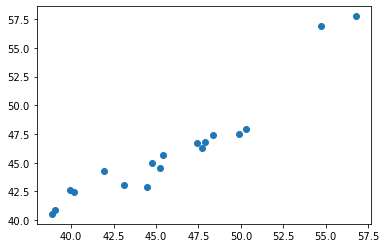

In [105]:
plt.scatter(y_test,predicciones)

<AxesSubplot:xlabel='TC', ylabel='Count'>

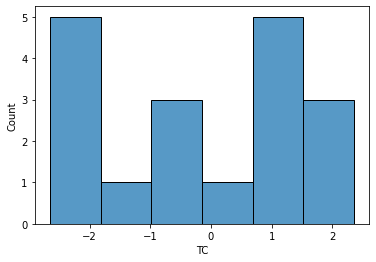

In [106]:
residuos = y_test - predicciones
sns.histplot(residuos)

In [107]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [108]:
print('Error Absoluto Medio: ', mean_absolute_error(y_test,predicciones))
print('Error Cuadratico Medio: ', mean_absolute_error(y_test,predicciones))
print('Raiz Error Cuadratico Medio: ', np.sqrt(mean_absolute_error(y_test,predicciones)))

Error Absoluto Medio:  1.428469176476815
Error Cuadratico Medio:  1.428469176476815
Raiz Error Cuadratico Medio:  1.195185833448847


In [109]:
X = sm.add_constant(df_scale)
modelo = sm.OLS(y.reset_index(drop=True),X)
result = modelo.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     TC   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     226.4
Date:                Tue, 06 Sep 2022   Prob (F-statistic):           7.41e-56
Time:                        12:00:54   Log-Likelihood:                -216.00
No. Observations:                 115   AIC:                             444.0
Df Residuals:                     109   BIC:                             460.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          42.8353      0.741     57.773      

# Conclusión

- Historicamente las variables seleccionadas tienen una correlación positiva con la variable objetivo, a excepción de la TPM

- Las unicas variables que influyen negativamente, es decir, que aportan a la disminucion de la tasa de cambio, es la TPM y la llegada de turistas

- Aunque no podemos evidenciar que las demas variables contribuyen positivamente (causalidad/correlacion) a la tasa de cambio, podemos notar que su incremento no crea una disminución, quizás contribuya a desacelerar el aumento, pero los niveles observados no han contribuido a la disminución como tal